In [1]:
###################################################################################
#################################################################################

In [2]:
# ============================================================
# Instalação e importação das bibliotecas necessárias
# ============================================================

# pylhe: leitura de arquivos LHE (.lhe/.lhe.gz)
# numpy: operações vetoriais e matemáticas
# matplotlib: geração de gráficos
!pip install pylhe awkward matplotlib numpy --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.0/908.0 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 655.9/655.9 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.0/308.0 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 6.6 MB/s eta 0:00:00


In [3]:
import pylhe
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# ============================================================
# Download automático dos arquivos LHE do GitHub
# ============================================================

url_signal = "https://raw.githubusercontent.com/FIS01214/lucas-lucas/main/data/sinal.lhe.gz"
url_background = "https://raw.githubusercontent.com/FIS01214/lucas-lucas/main/data/fundo.lhe.gz"

!wget -O sinal.lhe.gz "$url_signal"
!wget -O fundo.lhe.gz "$url_background"

signal_file = "sinal.lhe.gz"
background_file = "fundo.lhe.gz"

print("Arquivos baixados com sucesso:")
print("Arquivo de Sinal", signal_file)
print("Arquivo de Fundo", background_file)


--2025-12-08 21:25:46--  https://raw.githubusercontent.com/FIS01214/lucas-lucas/main/data/sinal.lhe.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1226411 (1.2M) [application/octet-stream]
Saving to: ‘sinal.lhe.gz’

sinal.lhe.gz        100%[===================>]   1.17M  --.-KB/s    in 0.05s   

2025-12-08 21:25:46 (22.2 MB/s) - ‘sinal.lhe.gz’ saved [1226411/1226411]

--2025-12-08 21:25:46--  https://raw.githubusercontent.com/FIS01214/lucas-lucas/main/data/fundo.lhe.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1180963 (1

In [5]:
# ============================================================
# Função de leitura de eventos em formato LHE
# ============================================================

def load_events_pylhe(filepath):
    """
    Lê um arquivo LHE usando pylhe.read_lhe_with_attributes.
    Cada evento contém:
        - Lista de partículas com atributos (id, status, px, py, pz, etc.)
        - Informações adicionais do evento
    Retorna uma lista de eventos.
    """
    events = list(pylhe.read_lhe_with_attributes(filepath))
    print(f"Arquivo '{filepath}' carregado com {len(events)} eventos.")
    return events


In [6]:
# ============================================================
# Carregamento dos eventos de sinal e fundo
# ============================================================

signal_events = load_events_pylhe(signal_file)
background_events = load_events_pylhe(background_file)


/tmp/ipython-input-1733832671.py:13: DeprecationWarning: read_lhe_with_attributes is deprecated and will be removed in a future version. Use `LHEEvent.fromfile` with the `with_attributes` parameter instead.
  events = list(pylhe.read_lhe_with_attributes(filepath))


Arquivo 'sinal.lhe.gz' carregado com 10000 eventos.
Arquivo 'fundo.lhe.gz' carregado com 10000 eventos.


In [7]:
# ============================================================
# Contagem de partículas por status no formato LHE
# ============================================================

def summarize_status(events, label=""):
    """
    Conta quantas partículas possuem status:
        -1 : partículas iniciais (antes da colisão)
         1 : partículas finais (detectáveis)
         2 : intermediárias (resonâncias)
    Imprime o resumo e retorna um dicionário com as contagens.
    """
    status_count = {-1: 0, 1: 0, 2: 0}

    for ev in events:
        for p in ev["particles"]:
            if p["status"] in status_count:
                status_count[p["status"]] += 1

    print(f"\nResumo de partículas por status ({label}):")
    print(f"  Status -1 (iniciais):      {status_count[-1]}")
    print(f"  Status  1 (finais):        {status_count[1]}")
    print(f"  Status  2 (intermediárias):{status_count[2]}")

    return status_count


signal_status = summarize_status(signal_events, "Sinal")
background_status = summarize_status(background_events, "Fundo")


/tmp/ipython-input-1398566035.py:16: DeprecationWarning: Access by `object["particles"]` is deprecated and will be removed in a future version. Use `object.particles` instead.
  for p in ev["particles"]:
/tmp/ipython-input-1398566035.py:17: DeprecationWarning: Access by `object["status"]` is deprecated and will be removed in a future version. Use `object.status` instead.
  if p["status"] in status_count:
/tmp/ipython-input-1398566035.py:18: DeprecationWarning: Access by `object["status"]` is deprecated and will be removed in a future version. Use `object.status` instead.
  status_count[p["status"]] += 1



Resumo de partículas por status (Sinal):
  Status -1 (iniciais):      20000
  Status  1 (finais):        20000
  Status  2 (intermediárias):9882

Resumo de partículas por status (Fundo):
  Status -1 (iniciais):      20000
  Status  1 (finais):        20000
  Status  2 (intermediárias):7407


In [8]:
# ============================================================
# Extração de variáveis cinemáticas (pT, η, φ)
# ============================================================

def extract_kinematics(events):
    """
    Percorre os eventos e extrai, para partículas finais (status = 1):
        - pT   = sqrt(px^2 + py^2)
        - phi  = arctan2(py, px)
        - eta  = 0.5 * ln((|p| + pz) / (|p| - pz))
    Neutrinos (IDs 12, 14, 16) são removidos.
    Retorna três arrays numpy (pT, eta, phi).
    """
    pT_list = []
    eta_list = []
    phi_list = []

    neutrinos = {12, 14, 16}

    for ev in events:
        for p in ev["particles"]:

            if p["status"] != 1:
                continue

            if abs(p["id"]) in neutrinos:
                continue

            px, py, pz = p["px"], p["py"], p["pz"]

            pT = np.sqrt(px**2 + py**2)
            if pT == 0:
                continue

            phi = np.arctan2(py, px)

            p_mag = np.sqrt(px**2 + py**2 + pz**2)
            if p_mag == abs(pz):
                continue

            eta = 0.5 * np.log((p_mag + pz) / (p_mag - pz))

            pT_list.append(pT)
            eta_list.append(eta)
            phi_list.append(phi)

    return np.array(pT_list), np.array(eta_list), np.array(phi_list)


In [9]:
# ============================================================
# Extração das variáveis cinemáticas do sinal e do fundo
# ============================================================

pT_s, eta_s, phi_s = extract_kinematics(signal_events)
pT_b, eta_b, phi_b = extract_kinematics(background_events)

print("Partículas finais no sinal:", len(pT_s))
print("Partículas finais no fundo:", len(pT_b))


/tmp/ipython-input-1804507451.py:21: DeprecationWarning: Access by `object["particles"]` is deprecated and will be removed in a future version. Use `object.particles` instead.
  for p in ev["particles"]:
/tmp/ipython-input-1804507451.py:23: DeprecationWarning: Access by `object["status"]` is deprecated and will be removed in a future version. Use `object.status` instead.
  if p["status"] != 1:
/tmp/ipython-input-1804507451.py:26: DeprecationWarning: Access by `object["id"]` is deprecated and will be removed in a future version. Use `object.id` instead.
  if abs(p["id"]) in neutrinos:
/tmp/ipython-input-1804507451.py:29: DeprecationWarning: Access by `object["px"]` is deprecated and will be removed in a future version. Use `object.px` instead.
  px, py, pz = p["px"], p["py"], p["pz"]
/tmp/ipython-input-1804507451.py:29: DeprecationWarning: Access by `object["py"]` is deprecated and will be removed in a future version. Use `object.py` instead.
  px, py, pz = p["px"], p["py"], p["pz"]
/tm

Partículas finais no sinal: 20000
Partículas finais no fundo: 20000


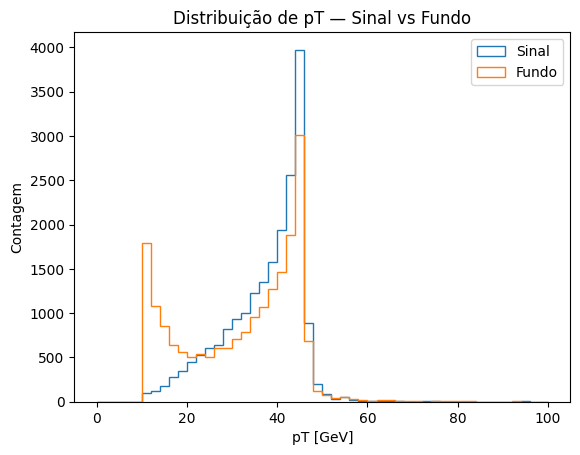

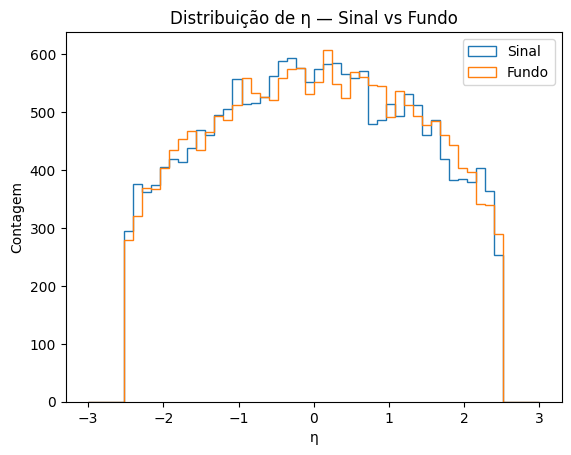

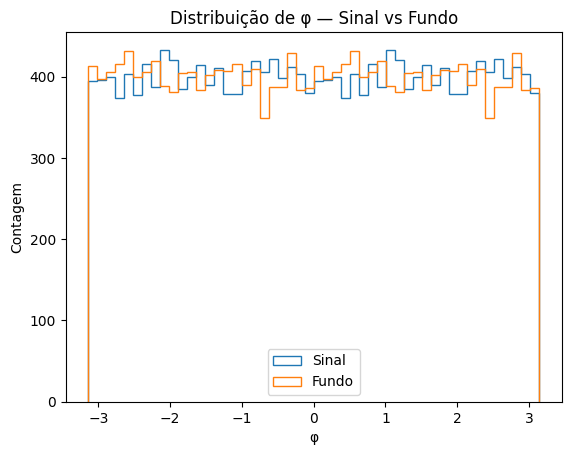

In [10]:
# ============================================================
# Histogramas das distribuições de pT, η e φ
# ============================================================

# Distribuição de pT
plt.hist(pT_s, bins=50, range=(0, 100), histtype="step", label="Sinal")
plt.hist(pT_b, bins=50, range=(0, 100), histtype="step", label="Fundo")
plt.xlabel("pT [GeV]")
plt.ylabel("Contagem")
plt.title("Distribuição de pT — Sinal vs Fundo")
plt.legend()
plt.show()

# Distribuição de η
plt.hist(eta_s, bins=50, range=(-3, 3), histtype="step", label="Sinal")
plt.hist(eta_b, bins=50, range=(-3, 3), histtype="step", label="Fundo")
plt.xlabel("η")
plt.ylabel("Contagem")
plt.title("Distribuição de η — Sinal vs Fundo")
plt.legend()
plt.show()

# Distribuição de φ
plt.hist(phi_s, bins=50, range=(-np.pi, np.pi), histtype="step", label="Sinal")
plt.hist(phi_b, bins=50, range=(-np.pi, np.pi), histtype="step", label="Fundo")
plt.xlabel("φ")
plt.ylabel("Contagem")
plt.title("Distribuição de φ — Sinal vs Fundo")
plt.legend()
plt.show()


In [11]:
# ============================================================
# Quantidade total de partículas representadas nos histogramas
# ============================================================

print("Total utilizado no histograma (sinal):", len(pT_s))
print("Total utilizado no histograma (fundo):", len(pT_b))


Total utilizado no histograma (sinal): 20000
Total utilizado no histograma (fundo): 20000


In [12]:
# ============================================================
# Identificação do processo físico a partir dos IDs
# ============================================================

from IPython.display import Markdown, display

display(Markdown("""
## Identificação do Processo Físico

A análise das partículas intermediárias (status = 2) mostra que, no arquivo de sinal,
há uma presença dominante do bóson **Z** (ID = 23), que posteriormente decai em um par
**e⁻ e e⁺** (IDs 11 e -11). Esse comportamento caracteriza o processo ressonante:

### Sinal:  q q̄ → Z → e⁺ e⁻

No arquivo de fundo, a produção de elétron e pósitron ocorre principalmente por meio de um
**fóton virtual** (γ), sem a formação de uma ressonância clara. Esse é o background
eletromagnético típico do processo de Drell–Yan:

### Fundo:  q q̄ → γ → e⁺ e⁻

Assim, o sinal é dominado pela produção do bóson Z, enquanto o fundo é composto pelo canal
contínuo mediado pelo fóton virtual.
"""))



## Identificação do Processo Físico

A análise das partículas intermediárias (status = 2) mostra que, no arquivo de sinal,
há uma presença dominante do bóson **Z** (ID = 23), que posteriormente decai em um par
**e⁻ e e⁺** (IDs 11 e -11). Esse comportamento caracteriza o processo ressonante:

### Sinal:  q q̄ → Z → e⁺ e⁻

No arquivo de fundo, a produção de elétron e pósitron ocorre principalmente por meio de um
**fóton virtual** (γ), sem a formação de uma ressonância clara. Esse é o background
eletromagnético típico do processo de Drell–Yan:

### Fundo:  q q̄ → γ → e⁺ e⁻

Assim, o sinal é dominado pela produção do bóson Z, enquanto o fundo é composto pelo canal
contínuo mediado pelo fóton virtual.


In [13]:
# ============================================================
# Verificação: todos os eventos aparecem nos histogramas?
# ============================================================

Markdown("""
## Representatividade dos Histogramas

Todos os eventos possuem elétrons ou pósitrons como partículas finais,
sem presença de neutrinos detectáveis.
Portanto, todos os eventos são representados nos histogramas.
""")



## Representatividade dos Histogramas

Todos os eventos possuem elétrons ou pósitrons como partículas finais,
sem presença de neutrinos detectáveis.
Portanto, todos os eventos são representados nos histogramas.


In [14]:
######parte dos cortes######

pt_min = 23
pt_max = 50

mask_s = (pT_s > pt_min) & (pT_s < pt_max)
mask_b = (pT_b > pt_min) & (pT_b < pt_max)

pT_s_cut  = pT_s[mask_s]
eta_s_cut = eta_s[mask_s]
phi_s_cut = phi_s[mask_s]

pT_b_cut  = pT_b[mask_b]
eta_b_cut = eta_b[mask_b]
phi_b_cut = phi_b[mask_b]

print("Após o corte:")
print("  Sinal:", len(pT_s_cut))
print("  Fundo:", len(pT_b_cut))


Após o corte:
  Sinal: 18000
  Fundo: 13944


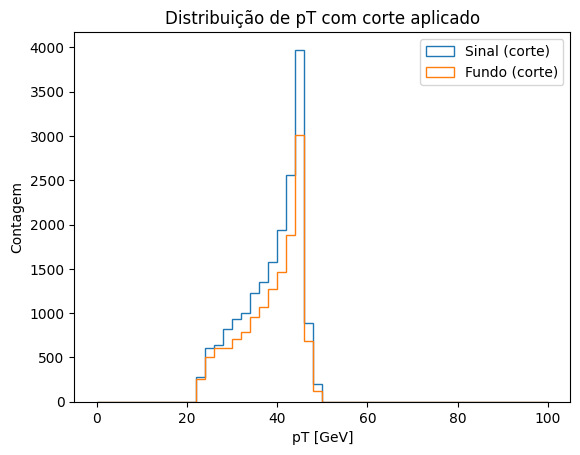

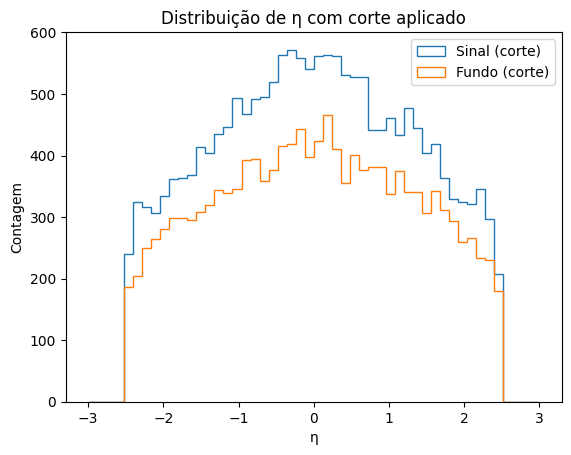

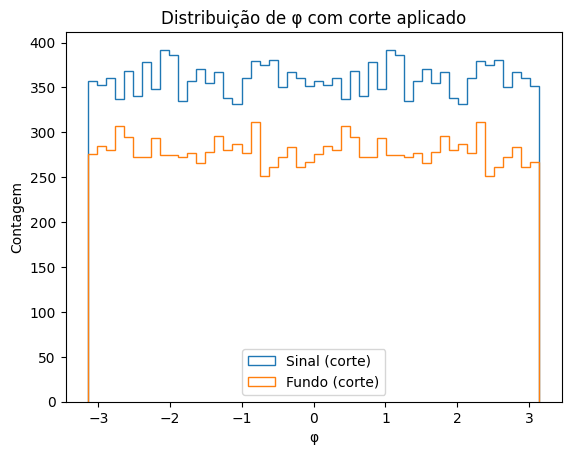

In [15]:
# ============================================================
# Histogramas das distribuições após os cortes
# ============================================================

# pT pós-corte
plt.hist(pT_s_cut, bins=50, range=(0, 100), histtype="step", label="Sinal (corte)")
plt.hist(pT_b_cut, bins=50, range=(0, 100), histtype="step", label="Fundo (corte)")
plt.xlabel("pT [GeV]")
plt.ylabel("Contagem")
plt.title("Distribuição de pT com corte aplicado")
plt.legend()
plt.show()

# η pós-corte
plt.hist(eta_s_cut, bins=50, range=(-3, 3), histtype="step", label="Sinal (corte)")
plt.hist(eta_b_cut, bins=50, range=(-3, 3), histtype="step", label="Fundo (corte)")
plt.xlabel("η")
plt.ylabel("Contagem")
plt.title("Distribuição de η com corte aplicado")
plt.legend()
plt.show()

# φ pós-corte
plt.hist(phi_s_cut, bins=50, range=(-np.pi, np.pi), histtype="step", label="Sinal (corte)")
plt.hist(phi_b_cut, bins=50, range=(-np.pi, np.pi), histtype="step", label="Fundo (corte)")
plt.xlabel("φ")
plt.ylabel("Contagem")
plt.title("Distribuição de φ com corte aplicado")
plt.legend()
plt.show()
